In [3]:
#@title ▶️ Base dir setup
import os, sys

# check if hosted (Google VM) or running on local server
if 'google.colab' in sys.modules:
  #@markdown Google Drive root folder - hosted by Google VM (adapt to your local paths)
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  base_dir = 'CV/' #@param {type: "string"}
  base_dir  = os.path.join('/content/drive/MyDrive/', base_dir)
  #MODIFY THESE PATHS TO POINT TO YOUR IMAGES
  img_dir = 'data/img/'
  vid_dir = 'data/video/'
  out_dir = 'output/'
  
  # move to base_dir 
  os.chdir(base_dir)
else:
  #MODIFY THESE PATHS TO POINT TO YOUR IMAGES
  img_dir = './img/'
  out_dir = './output/'

print("Current dir:", os.getcwd())

Current dir: /Users/raffaella/Library/CloudStorage/OneDrive-UniversitàdegliStudidiMilano/Raffaella Unimi/materiale didattica/Visione Artificiale/Visione_Artificiale_2024-25/Lectures/PARTE I/Labs/Lab05_StereoVision


In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pylab as plt

In [5]:
imgL = cv2.imread(img_dir + 'im_bike0.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(img_dir + 'im_bike1.png', cv2.IMREAD_GRAYSCALE)

In [6]:

# Calcolo della Matrice Essenziale (E)

# Trova i punti di interesse e le corrispondenze tra le immagini stereo
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(imgL, None)
keypoints2, descriptors2 = orb.detectAndCompute(imgR, None)

# Usa il matcher di BF (Brute Force) per trovare le corrispondenze tra i descrittori
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance)

# Estrai le coordinate dei punti corrispondenti
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Calcola la Matrice Essenziale (E) usando la matrice intrinseca della camera (assumiamo fittizia)
focal_length = 700  # Valore di esempio, da sostituire con il reale
principal_point = (imgL.shape[1] / 2, imgL.shape[0] / 2)  # Centro dell'immagine

K = np.array([[focal_length, 0, principal_point[0]],
              [0, focal_length, principal_point[1]],
              [0, 0, 1]])

E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

# Visualizzare il numero di corrispondenze trovate e verificare la matrice Essenziale
print("Numero di corrispondenze:", len(matches))
print("Matrice Essenziale (E):\n", E)


Numero di corrispondenze: 210
Matrice Essenziale (E):
 [[-3.80716922e-15 -6.62312279e-15  4.50552570e-17]
 [ 1.43951546e-14  6.30773599e-16 -7.07106781e-01]
 [ 8.04236338e-15  7.07106781e-01 -1.35728962e-15]]


# Epipolar geometry
https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html

- Find the keypoints and matches

In [7]:
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(imgL,None)
kp2, des2 = sift.detectAndCompute(imgR,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

- Find the Fundamental matrix and verify the fundamental constraint:

In [8]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
# Estimate the fundamental matrix
F, mask = cv2.findFundamentalMat(pts1, pts2)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [9]:
F

array([[-3.01678034e-09, -7.31746642e-06,  5.00679762e-03],
       [ 7.50715727e-06, -1.57938063e-07,  8.82095778e-02],
       [-5.16613770e-03, -8.94366467e-02,  1.00000000e+00]])

In [10]:
#Verifico il vincolo fondamentale: pim1' * F * pim2 = 0

N = pts1.shape[0]

p_im1_tilde = np.ones((3,N))
p_im1_tilde[0:2,:] = pts1.T

p_im2_tilde = np.ones ((3,N))
p_im2_tilde[0:2,:] = pts2.T

for i in range(N):
  res = np.dot(np.dot(np.transpose(p_im1_tilde[:,i]), F),  p_im2_tilde[:,i])
  print(i, res.astype(int))
 

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 1
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 -3
137 0
138 0
139 -1
140 -1
141 -1
142 -1
143 -1
144 0
145 0
146 -1
147 0
148 0
149 -1
150 -1
151 -1
152 0
153 -1
154 -1
155 -1
156 -1
157 -1
158 -1
159 -1
160 -1
161 -1
162 -1
163 -1
164 -3
165 -1
166 -1
167 -1
168 -1
169 -1
170 -1
171 -1
172 -1
173 0
174 -1
175 -1
176 -1
177 -1
178 -1
1

- Find epilines

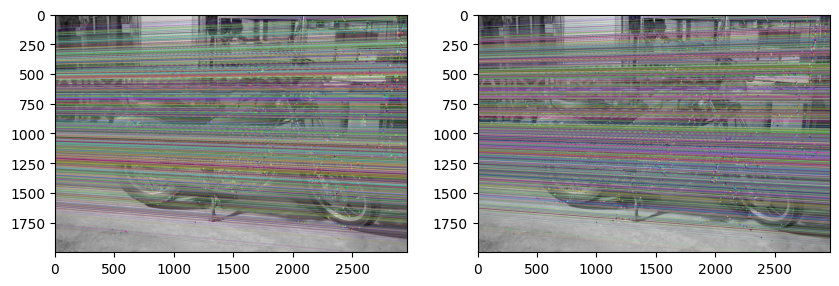

In [11]:
# Next we find the epilines. 
# Epilines corresponding to the points in first image is drawn on second image. 
# So mentioning of correct images are important here. We get an array of lines. 
# So we define a new function to draw these lines on the images.
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(imgL,imgR,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(imgL,imgR,lines2,pts2,pts1)
plt.figure(figsize=(10, 8))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()   

# DISPARITY MAP

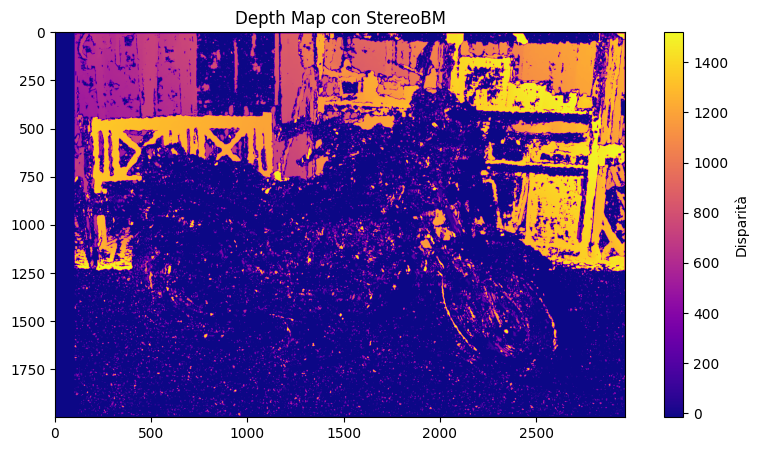

In [ ]:

# Calcolo della Depth Map usando StereoBM
stereo = cv2.StereoBM_create(numDisparities=16*6, blockSize=15) 
#16*6 = 96 livelli di disparità, quindi l'algoritmo cercherà corrispondenze fino a 96 pixel di distanza tra le due immagini.

disparity = stereo.compute(imgL, imgR)

# Mostrare la Depth Map
plt.figure(figsize=(10,5))
plt.imshow(disparity, cmap='plasma')
plt.colorbar(label="Disparità")
plt.title("Depth Map con StereoBM")
plt.show()


# DEPTH MAP

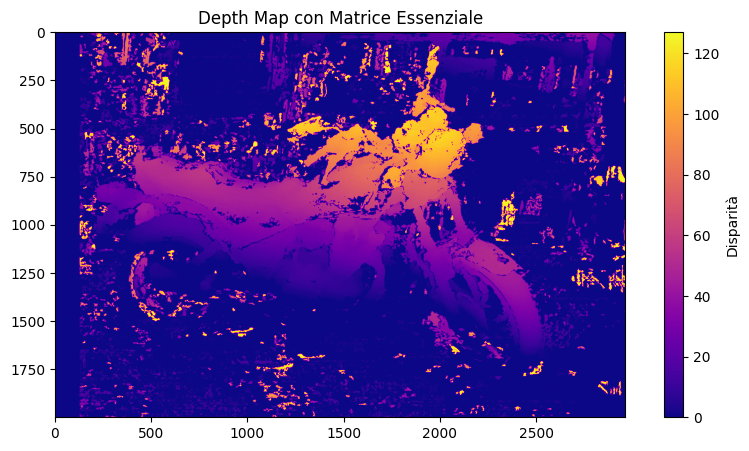

In [14]:

# Calcolo della Depth Map utilizzando la Matrice Essenziale

# Supponiamo che la matrice essenziale E sia già stata calcolata nel notebook
# e che i punti corrispondenti siano stati trovati nelle due immagini.

# Decomposizione della Matrice Essenziale per ottenere R e T
R1, R2, T = cv2.decomposeEssentialMat(E)

# Scegliamo una combinazione corretta di R e T
R = R1  # Supponiamo che R1 sia la rotazione corretta
T = T   # Il vettore traslazione rimane invariato

# Calcoliamo le matrici di proiezione delle due camere
P1 = np.hstack((np.eye(3), np.zeros((3,1))))  # Matrice di proiezione della prima camera
P2 = np.hstack((R, T))  # Matrice di proiezione della seconda camera

# Rettificazione delle immagini per allinearle
height, width = imgL.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(pts1, pts2, E, (width, height))

imgL_rectified = cv2.warpPerspective(imgL, H1, (width, height))
imgR_rectified = cv2.warpPerspective(imgR, H2, (width, height))

# Ora possiamo calcolare la Depth Map con StereoSGBM dopo la rettifica
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16*8,  # Deve essere multiplo di 16
    blockSize=9,
    P1=8 * 3 * 9**2,
    P2=32 * 3 * 9**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)

disparity_essential = stereo.compute(imgL_rectified, imgR_rectified).astype(np.float32) / 16.0

# Mostrare la Depth Map basata sulla Matrice Essenziale
plt.figure(figsize=(10,5))
plt.imshow(disparity_essential, cmap='plasma', vmin=0, vmax=np.max(disparity_essential))
plt.colorbar(label="Disparità")
plt.title("Depth Map con Matrice Essenziale")
plt.show()
